In this notebook, i'm testing a simple RNN on IMDB dataset from keras. Indeed other advanced RNNs can be used but let's start with a simple one.

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Input, SimpleRNN, Dropout, LSTM
from keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
tf.config.experimental.set_visible_devices([], "GPU") # Desable GPU for this task (if you're using one)

In [4]:
# Load data
imdb = datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

### EDA

Training set shape: (25000,)
Test set shape: (25000,)
Number of unique words: 88584


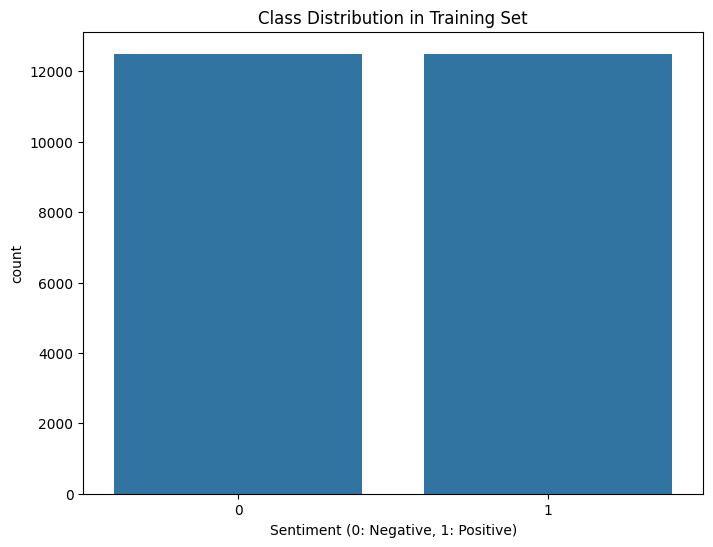

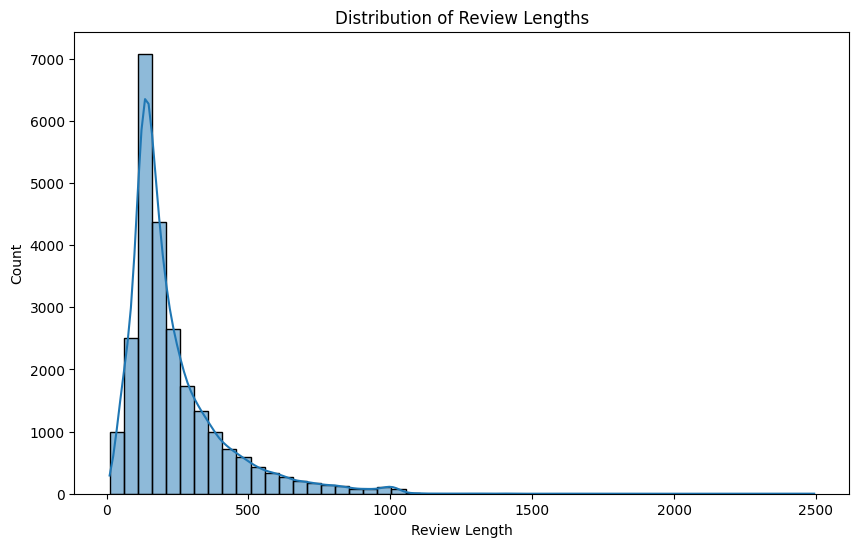

Average review length: 238.71
Median review length: 178.00
Max review length: 2494
Min review length: 11


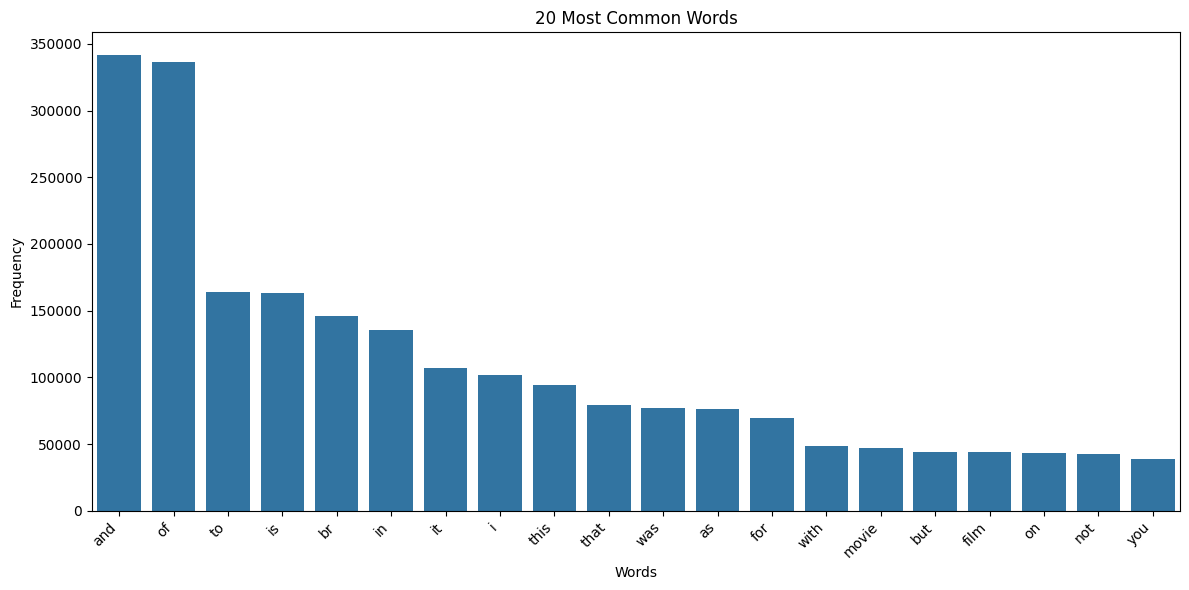

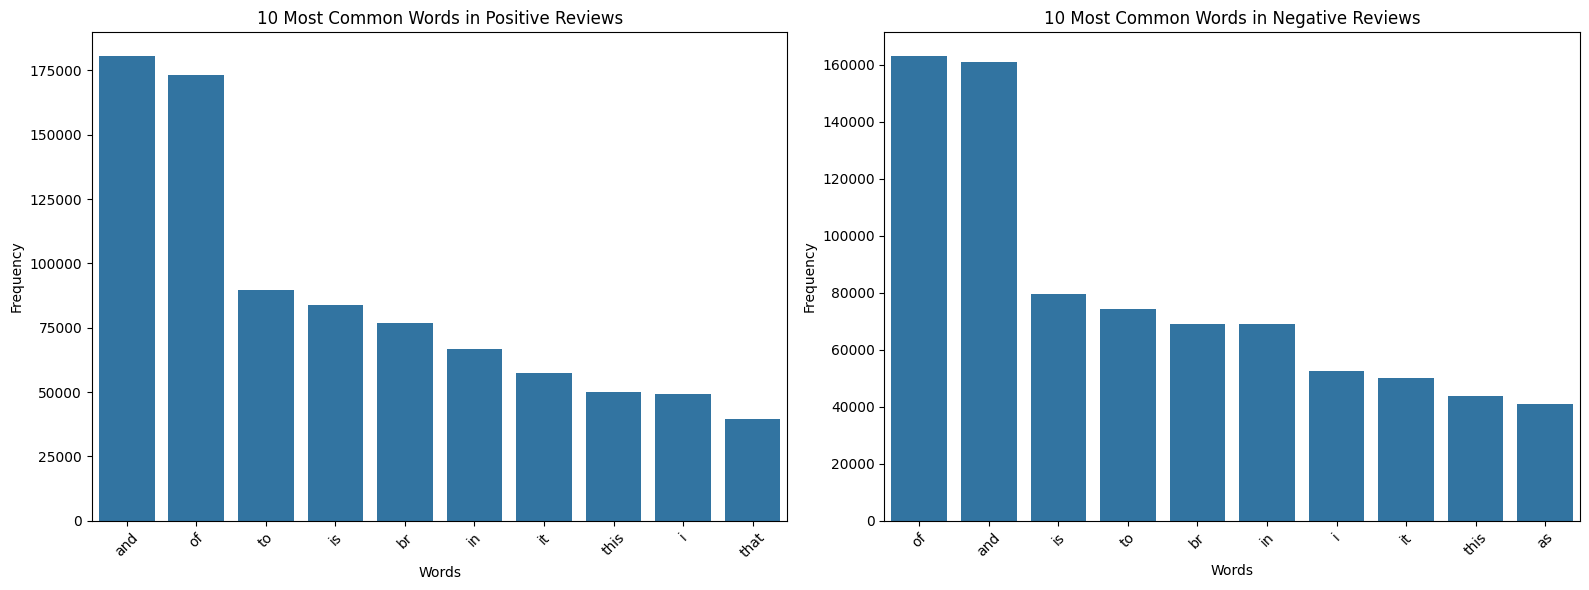

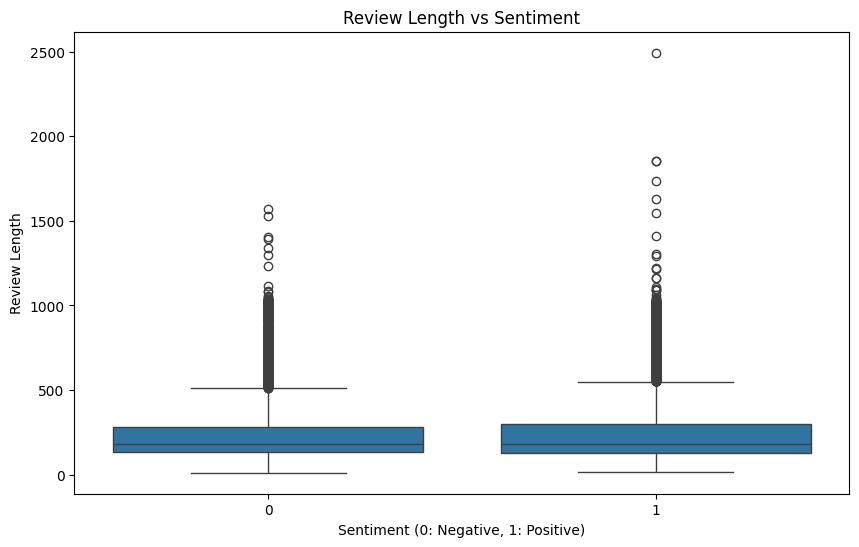

In [5]:
# Pipeline to perform EDA
class IMDBDataAnalyzer:
    def __init__(self, num_words=10000):
        self.num_words = num_words
        self.load_data()
        self.prepare_word_index()

    def load_data(self):
        (self.X_train, self.y_train), (self.X_test, self.y_test) = imdb.load_data(num_words=self.num_words)

    def prepare_word_index(self):
        self.word_index = imdb.get_word_index()
        self.index_word = {v: k for k, v in self.word_index.items()}

    def indices_to_text(self, indices):
        return ' '.join([self.index_word.get(i - 3, '?') for i in indices])

    def basic_info(self):
        print(f"Training set shape: {self.X_train.shape}")
        print(f"Test set shape: {self.X_test.shape}")
        print(f"Number of unique words: {len(self.word_index)}")

    def plot_class_distribution(self):
        plt.figure(figsize=(8, 6))
        sns.countplot(x=self.y_train)
        plt.title('Class Distribution in Training Set')
        plt.xlabel('Sentiment (0: Negative, 1: Positive)')
        plt.show()

    def analyze_review_lengths(self):
        review_lengths = [len(x) for x in self.X_train]
        plt.figure(figsize=(10, 6))
        sns.histplot(review_lengths, bins=50, kde=True)
        plt.title('Distribution of Review Lengths')
        plt.xlabel('Review Length')
        plt.show()

        print(f"Average review length: {np.mean(review_lengths):.2f}")
        print(f"Median review length: {np.median(review_lengths):.2f}")
        print(f"Max review length: {np.max(review_lengths)}")
        print(f"Min review length: {np.min(review_lengths)}")

    def plot_common_words(self):
        all_words = [word for review in self.X_train for word in review]
        word_freq = Counter(all_words)
        common_words = word_freq.most_common(20)

        plt.figure(figsize=(12, 6))
        sns.barplot(x=[self.index_word.get(word, '?') for word, _ in common_words], y=[count for _, count in common_words])
        plt.title('20 Most Common Words')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def analyze_sentiment_words(self):
        positive_words = [word for review, sentiment in zip(self.X_train, self.y_train) if sentiment == 1 for word in review]
        negative_words = [word for review, sentiment in zip(self.X_train, self.y_train) if sentiment == 0 for word in review]

        positive_freq = Counter(positive_words)
        negative_freq = Counter(negative_words)

        common_positive = positive_freq.most_common(10)
        common_negative = negative_freq.most_common(10)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        sns.barplot(x=[self.index_word.get(word, '?') for word, _ in common_positive], y=[count for _, count in common_positive], ax=ax1)
        ax1.set_title('10 Most Common Words in Positive Reviews')
        ax1.set_xlabel('Words')
        ax1.set_ylabel('Frequency')
        ax1.tick_params(axis='x', rotation=45)

        sns.barplot(x=[self.index_word.get(word, '?') for word, _ in common_negative], y=[count for _, count in common_negative], ax=ax2)
        ax2.set_title('10 Most Common Words in Negative Reviews')
        ax2.set_xlabel('Words')
        ax2.set_ylabel('Frequency')
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def analyze_length_vs_sentiment(self):
        lengths = [len(review) for review in self.X_train]
        df = pd.DataFrame({'length': lengths, 'sentiment': self.y_train})

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='sentiment', y='length', data=df)
        plt.title('Review Length vs Sentiment')
        plt.xlabel('Sentiment (0: Negative, 1: Positive)')
        plt.ylabel('Review Length')
        plt.show()

    def run_eda(self):
        self.basic_info()
        self.plot_class_distribution()
        self.analyze_review_lengths()
        self.plot_common_words()
        self.analyze_sentiment_words()
        self.analyze_length_vs_sentiment()

# Run pipeline
analyzer = IMDBDataAnalyzer()
analyzer.run_eda()

In [6]:
print('length of sequence 0:', len(X_train[0]))
print('length of sequence 1:', len(X_train[1]))

length of sequence 0: 218
length of sequence 1: 189


In [7]:
words_map = imdb.get_word_index()
result = {word: k for word in X_train[0] for k, v in words_map.items() if v == word}
result


{1: 'the',
 14: 'as',
 22: 'you',
 16: 'with',
 43: 'out',
 530: 'themselves',
 973: 'powerful',
 1622: 'lets',
 1385: 'loves',
 65: 'their',
 458: 'becomes',
 4468: 'reaching',
 66: 'had',
 3941: 'journalist',
 4: 'of',
 173: 'lot',
 36: 'from',
 256: 'anyone',
 5: 'to',
 25: 'have',
 100: 'after',
 838: 'atmosphere',
 112: 'never',
 50: 'more',
 670: 'room',
 2: 'and',
 9: 'it',
 35: 'so',
 480: 'heart',
 284: 'shows',
 150: 'years',
 172: 'every',
 167: 'going',
 336: 'help',
 385: 'moments',
 39: 'or',
 4536: 'chest',
 1111: 'visual',
 17: 'movie',
 546: 'except',
 38: 'her',
 13: 'was',
 447: 'several',
 192: 'enough',
 6: 'is',
 147: 'now',
 2025: 'current',
 19: 'film',
 1920: 'mine',
 4613: 'potentially',
 469: 'unfortunately',
 71: 'than',
 87: 'him',
 12: 'that',
 76: 'get',
 15: 'for',
 1247: 'camp',
 515: 'sometimes',
 626: 'scary',
 18: 'but',
 62: 'story',
 386: 'wonderful',
 8: 'in',
 316: 'seeing',
 106: 'character',
 2223: '70s',
 5244: 'musicians',
 3785: 'shadows',
 

#### Padding

In [8]:
X_train_s = X_train[:10000]
X_test_s = X_test[:10000]

In [9]:
X_train_padd = sequence.pad_sequences(X_train_s,
                                 value=0,
                                 padding='post', # to add zeros at the end
                                 truncating='post', # to cut the end of long sequences
                                 maxlen=128) # the length we want

X_test_padd = sequence.pad_sequences(X_test_s,
                                value=0,
                                padding='post', # to add zeros at the end
                                truncating='post', # to cut the end of long sequences
                                maxlen=128) # the length we want

In [10]:
print("X_train after padding", X_train_padd.shape)
print("X_test after padding", X_test_padd.shape)

X_train after padding (10000, 128)
X_test after padding (10000, 128)


In [11]:
print(len(X_train_padd[0]))
print(len(X_test_padd[1]))

128
128


In [12]:
X_train_padd[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5], dtype=int32)

---
#### SimpleRNN implementation with Numpy

In [13]:
# From Deep Learning with Python - François Chollet

timesteps = 1000 # 1000 review (sentence)
input_features = 32 # each sentence is encoded (embedding), the embeddings are the features
output_features = 64 #  number of ouputs at each time step ( & also size of the hidden state)

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features, ))

W = np.random.random((output_features, input_features))  # Weight matrix for input to hidden connections
U = np.random.random((output_features, output_features))  # Weight matrix for hidden to hidden connections
b = np.random.random((output_features,))  # Bias vector for hidden layer

successive_outputs = []

for input_t in inputs:
		output_t = np.tanh(np.dot(W, input_t) + b + np.dot(U, state_t) )
		successive_outputs.append(output_t)
		state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

---

In [14]:
# A simple RNN for movie reviews classification
def simple_RNN(input_length, vocab_size, embedding_dim, hidden_units):
    model = Sequential([
        Input(shape=(input_length,)),
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        SimpleRNN(units=hidden_units),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
input_shape = X_train_padd.shape

In [16]:
input_length = 200  # Maximum length of reviews (pad or truncate to this length)
vocab_size = 10000  # Size of your vocabulary
embedding_dim = 32  # Dimensionality of the embedding layer
hidden_units = 64   # Number of units in the SimpleRNN layer

rnn_model = simple_RNN(input_length, vocab_size, embedding_dim, hidden_units)
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,273 (1.24 MB)

 Trainable params: 326,273 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
y_train = y_train[:10000]
y_test = y_test[:10000]
y_train.shape

(10000,)

In [18]:
# Define now our callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3),
    # TensorBoard(
    #     log_dir=os.path.join("./training_logs", datetime.now().isoformat()),
    #     histogram_freq=0,
    #     write_images=True,
    # ),
]

rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
rnn_model.fit(x=X_train_padd, 
                    y=y_train, 
                    validation_split=.2,
                    epochs=30,
                    batch_size=32, callbacks=callbacks)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5057 - loss: 0.6982 - val_accuracy: 0.5105 - val_loss: 0.6932
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6086 - loss: 0.6663 - val_accuracy: 0.5050 - val_loss: 0.7051
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7750 - loss: 0.5193 - val_accuracy: 0.5000 - val_loss: 0.8279
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9019 - loss: 0.2315 - val_accuracy: 0.5110 - val_loss: 1.0447


In [21]:
loss, accuracy = rnn_model.evaluate(X_test_padd, y_test)
print("Loss on test set", loss)
print("Accuracy on test set", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5090 - loss: 1.0734
Loss on test set 1.0623879432678223
Accuracy on test set 0.5120000243186951


In [22]:
def lstm_model(input_length, vocab_size, embedding_dim, lstm_units):

    model = Sequential([
        Input(shape=(input_length,)),
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        LSTM(units=lstm_units, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

input_length = 200  # Maximum length of reviews (pad or truncate to this length)
vocab_size = 10000  # Size of your vocabulary
embedding_dim = 100  # Dimensionality of the embedding layer
lstm_units = 64     # Number of units in the LSTM layer

model_lstm = lstm_model(input_length, vocab_size, embedding_dim, lstm_units)
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046,465 (3.99 MB)

 Trainable params: 1,046,465 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model_lstm.fit(
    X_train_padd, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5401 - loss: 0.6852 - val_accuracy: 0.7665 - val_loss: 0.5182
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8216 - loss: 0.4320 - val_accuracy: 0.7990 - val_loss: 0.4733
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.8964 - loss: 0.3026 - val_accuracy: 0.7405 - val_loss: 0.5738
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7262 - loss: 0.5526 - val_accuracy: 0.7795 - val_loss: 0.5508
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9123 - loss: 0.2434 - val_accuracy: 0.6170 - val_loss: 0.6582


In [24]:
loss, accuracy = model_lstm.evaluate(X_test_padd, y_test)
print(f"Test accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7881 - loss: 0.4861
Test accuracy: 0.7877


As you can see LSTM is much more efficient.

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir training_logs

## Classical NLP

Now let's make a prediction using classical NLP tools: BOW and TF-IDF. Followed by a classification model such as logistic regression or random forest classifier.

Indices 0, 1 and 2 are reserved and mean:

- 0: padding tag
- 1: start tag
- 2: unknown tag

In [26]:
imdb.get_word_index()

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [27]:
from pprint import pprint
index_to_word = {v+3: k for k, v in imdb.get_word_index().items()}
index_to_word[0] = ''
index_to_word[1] = ''
index_to_word[2] = ''

indices_to_sentence = lambda x: ' '.join([index_to_word[w] for w in x]) # given a list of indices x, the function returns the associated sentence

pprint(indices_to_sentence(X_train[0]))

(' this film was just brilliant casting location scenery story direction '
 "everyone's really suited the part they played and you could just imagine "
 'being there robert  is an amazing actor and now the same being director  '
 'father came from the same scottish island as myself so i loved the fact '
 'there was a real connection with this film the witty remarks throughout the '
 'film were great it was just brilliant so much that i bought the film as soon '
 'as it was released for  and would recommend it to everyone to watch and the '
 'fly fishing was amazing really cried at the end it was so sad and you know '
 'what they say if you cry at a film it must have been good and this '
 "definitely was also  to the two little boy's that played the  of norman and "
 'paul they were just brilliant children are often left out of the  list i '
 'think because the stars that play them all grown up are such a big profile '
 'for the whole film but these children are amazing and should be pr

In [28]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

In [29]:
# Classification using NLP tools

X_train_10000 = X_train[10000:]
y_train_10000 = y_train[10000:]

X_test_10000 = X_train[:10000]
y_test_10000 = y_train[:10000]

In [30]:
t0 = time.time()
vectorizer = TfidfVectorizer(analyzer=(lambda x:x))
X_train_nlp = vectorizer.fit_transform(X_train_10000).toarray()
X_test_nlp = vectorizer.transform(X_test_10000).toarray()
duration = time.time() - t0
duration

1.2853753566741943

In [31]:
X_train_nlp.shape, X_test_nlp.shape, y_train_10000.shape, y_test_10000.shape

((15000, 9998), (10000, 9998), (15000,), (10000,))

In [32]:
lr_model = LogisticRegression()

lr_model.fit(X_train_nlp, y_train_10000)

LogisticRegression()

In [33]:
y_pred = lr_model.predict(X_test_nlp)

print("Accuracy", accuracy_score(y_pred, y_test_10000))
print(classification_report(y_pred, y_test_10000))

Accuracy 0.8855
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4824
           1       0.90      0.88      0.89      5176

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [34]:
param_grid = {'n_estimators': [10, 30],
              'max_depth': [None, 5, 10]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)

grid.fit(X_train_nlp, y_train_10000)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10], 'n_estimators': [10, 30]})

In [35]:

print("best params:", grid.best_params_)
print("accuracy on train:", grid.score(X_train_nlp, y_train_10000))
print("accuracy on test:", grid.score(X_test_nlp, y_test_10000))

best params: {'max_depth': None, 'n_estimators': 30}
accuracy on train: 0.9999333333333333
accuracy on test: 0.8073


In [62]:
lc = learning_curve(lr_model, X_train_nlp, y_train_10000)
lc

(array([ 1200,  3900,  6600,  9300, 12000]),
 array([[0.94166667, 0.9575    , 0.9575    , 0.9575    , 0.9575    ],
        [0.92794872, 0.92435897, 0.92974359, 0.92974359, 0.92974359],
        [0.92530303, 0.92636364, 0.92424242, 0.92090909, 0.92090909],
        [0.92548387, 0.92580645, 0.92301075, 0.92247312, 0.92290323],
        [0.9205    , 0.92375   , 0.92241667, 0.92141667, 0.92433333]]),
 array([[0.813     , 0.812     , 0.8       , 0.81333333, 0.80133333],
        [0.854     , 0.85866667, 0.847     , 0.86      , 0.84633333],
        [0.86766667, 0.87166667, 0.86466667, 0.87633333, 0.86166667],
        [0.87766667, 0.87633333, 0.87233333, 0.88066667, 0.869     ],
        [0.88      , 0.87833333, 0.87766667, 0.891     , 0.874     ]]))

(array([[1., 2., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 3., 0., 0., 0., 0., 0., 0., 0., 1.],
        [2., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
        [3., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [2., 1., 1., 0., 0., 0., 0., 0., 0., 1.]]),
 array([0.9205, 0.9242, 0.9279, 0.9316, 0.9353, 0.939 , 0.9427, 0.9464,
        0.9501, 0.9538, 0.9575]),
 <a list of 5 BarContainer objects>)

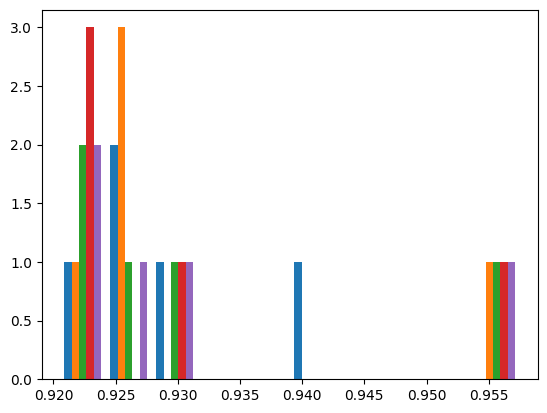

In [63]:
plt.hist(lc[1]) # accuracy on Xtrain

(array([[0., 1., 0., 0., 0., 1., 0., 1., 2., 0.],
        [0., 1., 0., 0., 0., 0., 1., 1., 2., 0.],
        [1., 0., 0., 0., 0., 1., 0., 2., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 2., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1., 1., 0.]]),
 array([0.8   , 0.8091, 0.8182, 0.8273, 0.8364, 0.8455, 0.8546, 0.8637,
        0.8728, 0.8819, 0.891 ]),
 <a list of 5 BarContainer objects>)

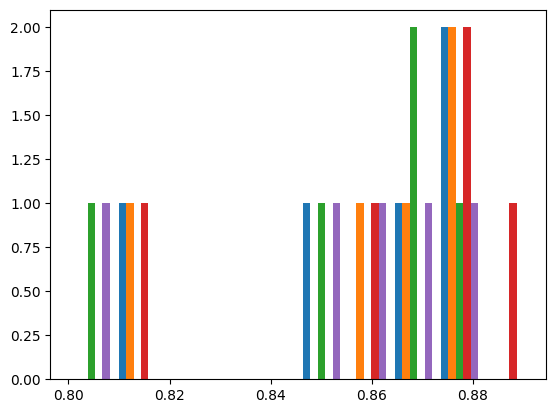

In [64]:
plt.hist(lc[2]) # accuracy on Xtest

Text(0.5, 1.0, 'Learning Curve for LogisticRegression')

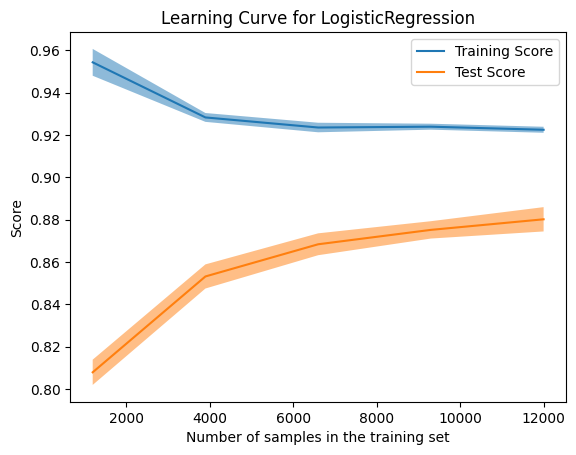

In [65]:
from sklearn.model_selection import LearningCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1,sharey=True)

LearningCurveDisplay.from_estimator(lr_model, X_train_nlp, y_train_10000, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {lr_model.__class__.__name__}")

Indeed the model is still overfitting but logistic regression's performance is clearly best.